<a href="https://colab.research.google.com/github/PRDrum5/pneumonia_xray/blob/main/pneumonia_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia X-Ray Dataset

https://data.mendeley.com/datasets/rscbjbr9sj/2



In [ ]:
!pip install plotly
!pip install plotly pillow
!pip install torcheval

import kagglehub
import random
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms.v2 import Compose, RandomResizedCrop, CenterCrop, Normalize, ToDtype
from torcheval.metrics.functional import binary_f1_score

In [ ]:
dataset_path = Path(kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia"))

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
data_path = dataset_path / "chest_xray"

train_path = data_path / "train"
test_path = data_path / "test"

assert train_path.exists() and test_path.exists()

Look at balance of positive and negative cases

In [ ]:
negative_cases_dir = train_path / "NORMAL"
positive_cases_dir = train_path / "PNEUMONIA"
assert negative_cases_dir.exists() and positive_cases_dir.exists()

negative_samples = list(negative_cases_dir.glob('*.jpeg'))
positive_samples = list(positive_cases_dir.glob('*.jpeg'))

counts = [len(positive_samples), len(negative_samples)]

labels = ["Positive Cases", "Negative Cases"]

fig = go.Figure(data=[go.Bar(x=labels, y=counts, marker_color=['green', 'red'])])

fig.update_layout(
    title="Data Imbalance in Training Data",
    xaxis_title="Positive and Negative Cases",
    yaxis_title="Number of Samples"
)

Visualise some of the data samples

In [ ]:
positive_sample_img = np.array(Image.open(positive_samples[0]))
negative_sample_img = np.array(Image.open(negative_samples[0]))

image_fig = make_subplots(rows=1, cols=2, subplot_titles=("Positive", "Negative"))
image_fig.add_trace(go.Heatmap(z=positive_sample_img, colorscale='gray'), 1, 1)
image_fig.add_trace(go.Heatmap(z=negative_sample_img, colorscale='gray'), 1, 2)

image_fig.update_yaxes(autorange='reversed', constrain='domain')
image_fig.update_xaxes(constrain='domain')
image_fig.show()

Create a PyTorch Dataloader

In [ ]:
class XRayTransformations:
    def __init__(self, shape):
        self.transforms = Compose([
            RandomResizedCrop(shape),
            ToDtype(torch.float32, scale=True),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def __call__(self, img):
        return self.transforms(img)


class XRayDataset(Dataset):
    def __init__(self, data_path: Path, transform=None):
        assert data_path.exists(), f"Data directory does not exist at: {data_path}"

        self.neg_samples_path = data_path / "NORMAL"
        self.pos_samples_path = data_path / "PNEUMONIA"

        assert self.neg_samples_path.exists(
        ), f"Negative samples directory does not exist at: {self.neg_samples_path}"
        assert self.pos_samples_path.exists(
        ), f"Positive samples directory does not exist at: {self.pos_samples_path}"

        neg_samples = self.parse_sample_files(self.neg_samples_path)
        pos_samples = self.parse_sample_files(self.pos_samples_path)
        self.labels = [0] * len(neg_samples) + [1] * len(pos_samples)
        self.samples = neg_samples + pos_samples

        self.samples, self.labels = self._shuffle_data()

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = read_image(self.samples[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def _shuffle_data(self):
        sample_label_pairs = list(zip(self.samples, self.labels))
        random.shuffle(sample_label_pairs)
        samples, labels = zip(*sample_label_pairs)
        return list(samples), list(labels)

    def parse_sample_files(self, samples_path: Path):
        # TODO: There are some file duplication here, these should be removed from the dataset.
        return list(samples_path.glob("*.jpeg"))


Create an instance of our dataloader.

In [ ]:
torch.manual_seed(42)
batch_size = 64

transforms = XRayTransformations(shape=(244, 244))
train_ds = XRayDataset(train_path, transform=transforms)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_transforms = XRayTransformations(shape=(244, 244))
test_ds = XRayDataset(test_path, transform=transforms)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

Create a model - use VGG and add some layers to the end

In [ ]:
vgg_model = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights.DEFAULT, progress=True)

# What is VGG11?

VGG11 (Visual Giometry Group) is a 11 layer pretrained neural network for image processing developed at Oxford Uni.

The model was originally created for the ImageNet image recognition challenge in 2014. Since it has become well known for being adapatable to other tasks after some fine-tuning.

It's not the *best* model, but it's quick and easy to work with - good for this PoC.

VGG16 has 133M parameters. ChatGPT style models have 1B to 90B parameters.

![image.png](https://debuggercafe.com/wp-content/uploads/2021/04/vgg.jpg)

In [ ]:
output_classes = 2 # NORMAL, PNEUMONIA
vgg_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=output_classes, bias=True)
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

We're going to fine tune the model, but we don't want to change all of it at once.
The first section extracts features from images, this doesn't need to be modified much.

The Classifier section can be tweaked a bit more (it's further from the input data so can change more)

The final layer is brand new so should be modifed a lot.

We'll define the parameters we're going to modify and give them different learning rates.

In [ ]:
image_features_params = []
image_features_names = ["features"]

classifier_input_params = []
classifier_input_names = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]

classifier_output_params = []
classifier_output_names = ["classifier.6.weight", "classifier.6.bias"]

# Collect all the parameters
for name, param in vgg_model.named_parameters():
    if image_features_names[0] in name:
        param.requires_grad = True
        image_features_params.append(param)
    elif name in classifier_input_names:
        param.requires_grad = True
        classifier_input_params.append(param)
    elif name in classifier_output_names:
        param.requires_grad = True
        classifier_output_params.append(param)
    else:
        # Disable learning on this parameter
        param.requires_grad = False

# Set an optimizer to modifiy the model parameters
optimizer = torch.optim.AdamW([
    {"params": image_features_params, "lr": 1e-4},
    {"params": classifier_input_params, "lr": 5e-4},
    {"params": classifier_output_params, "lr": 1e-3},
])

# Function which will provide the loss for training the model
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
# Write a training function to fine-tune the model for our dataset

def train_step(model, data_loader, loss_func, optimizer, epoch, epochs, device):
    print(f"Epoch {epoch+1}/{epochs}\n{'-'*12}")
    loss_log = 0
    acc_log = 0
    f1_log = 0
    seen_samples = 0

    model.train()
    for batch_id, (samples, labels) in enumerate(data_loader):
        # Send data to device
        samples = samples.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        preds = model(samples)
        loss = loss_func(preds, labels)
        loss.backward()

        optimizer.step()

        # Collect some performance stats.
        loss_log += loss.item()
        acc_log += torch.sum(torch.argmax(preds, dim=1) == labels)
        f1_log += binary_f1_score(torch.argmax(preds, dim=1), labels)

        if batch_id != len(data_loader):
            seen_samples += batch_size
            rolling_acc = acc_log / seen_samples
            rolling_loss = loss_log / seen_samples
            print(f"\rTraining Batch:{batch_id+1}/{len(data_loader)}\tLoss: {rolling_loss:.5f}\tAccuracy: {100*rolling_acc:.3f}%", end="", flush=True)

    epoch_acc = acc_log / len(data_loader.dataset)
    epoch_loss = loss_log / len(data_loader.dataset)
    epoch_f1 = f1_log / len(data_loader)

    print(f"\rTraining Loss: {epoch_loss:.5f}\tAccuracy: {100*epoch_acc:.3f}%\tF1 Score: {epoch_f1:.4f}\n", end="", flush=True)


def test_step(model, data_loader, loss_func, device):
    loss_log = 0
    acc_log = 0
    f1_log = 0
    seen_samples = 0

    model.eval()
    with torch.no_grad():
        for batch_id, (samples, labels) in enumerate(data_loader):
            # Send data to device
            samples = samples.to(device)
            labels = labels.to(device)

            preds = model(samples)
            loss = loss_func(preds, labels)

            # Collect some performance stats.
            loss_log += loss.item()
            acc_log += torch.sum(torch.argmax(preds, dim=1) == labels)
            f1_log += binary_f1_score(torch.argmax(preds, dim=1), labels)

    epoch_acc = acc_log / len(data_loader.dataset)
    epoch_loss = loss_log / len(data_loader.dataset)
    epoch_f1 = f1_log / len(data_loader)

    print(f"Test Loss: {epoch_loss:.5f}\tTest Accuracy: {100*epoch_acc:.3f}%\tF1 Score: {epoch_f1:.4f}\n")


def train(model, train_dataloader, test_dataloader, loss_func, optimizer, epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")

    model.to(device)
    torch.backends.cudnn.benchmark = True

    for epoch in range(epochs):
        train_step(model, train_dataloader, loss_func, optimizer, epoch, epochs, device)
        test_step(model, test_dataloader, loss_func, device)


Test output against precision and recall - visualise confusion matrix

In [ ]:
train(vgg_model, train_dataloader, test_dataloader, loss_func, optimizer, 5)

Using cuda:0
Epoch 1/5
------------
Training Loss: 0.00495	Accuracy: 86.503%	F1 Score: 0.9132
Test Loss: 0.00586	Test Accuracy: 79.006%	F1 Score: 0.8868

Epoch 2/5
------------
Training Loss: 0.00311	Accuracy: 92.082%	F1 Score: 0.9502
Test Loss: 0.00575	Test Accuracy: 80.929%	F1 Score: 0.9078

Epoch 3/5
------------
Training Loss: 0.00270	Accuracy: 92.561%	F1 Score: 0.9529
Training Loss: 0.00261	Accuracy: 93.021%	F1 Score: 0.9560
Test Loss: 0.00321	Test Accuracy: 84.295%	F1 Score: 0.9339

Epoch 5/5
------------
Training Loss: 0.00231	Accuracy: 93.999%	F1 Score: 0.9628
Test Loss: 0.00547	Test Accuracy: 82.051%	F1 Score: 0.9168



100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


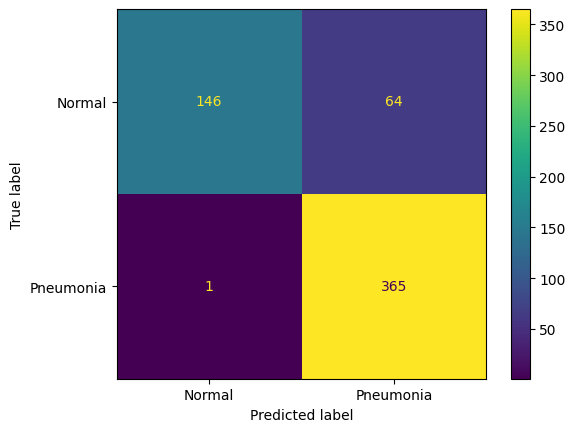

In [ ]:
def calc_confusion_matrix(model, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for samples, labels in tqdm(data_loader):
            samples = samples.to(device)

            preds = model(samples)
            preds = torch.argmax(preds, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels)

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    return confusion_matrix(all_labels, all_preds)

cm = calc_confusion_matrix(vgg_model, test_dataloader)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot();

In [ ]:
# Save the model
model_path = "xray_model.pth"
torch.save(vgg_model.state_dict(), model_path)